# Implementation of Spectral Clustering

In [1]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from scipy.linalg import eigh

In [398]:
from sklearn.datasets import make_moons

# Generate moon-shaped data
X, y = make_moons(n_samples=500, noise=0.05, random_state=42)

In [2]:
seed = 42

In [ ]:
# (600, 200) makes an inner and outer circle of 600 and 200 points
X1, y1 = make_circles(n_samples=(600, 200), noise=0.04, factor=0.5, random_state=seed)
y1 = y1 + 1     # Make the labels 1 and 2 (rather than 0 and 1)
X1 = X1*3       # Make each cirlce 3 times bigger.

# Make the center blob and circles into one dataset.
X = np.concatenate((X, X1), axis=0)
y = np.concatenate((y, y1), axis=0)

In [419]:
plot_colors = cm.tab10.colors
y_color = np.array(plot_colors)[y]      # Select apporpriate color from list of plot_colors using label as index.

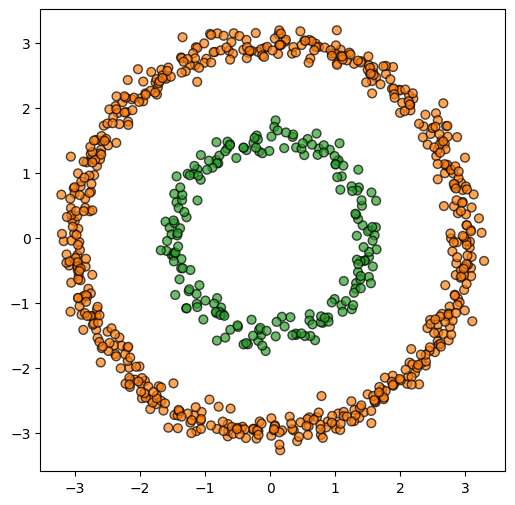

In [420]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], marker='o', s=40, color=y_color, alpha=0.7, edgecolors='black')

In [250]:
from sklearn.cluster import SpectralClustering

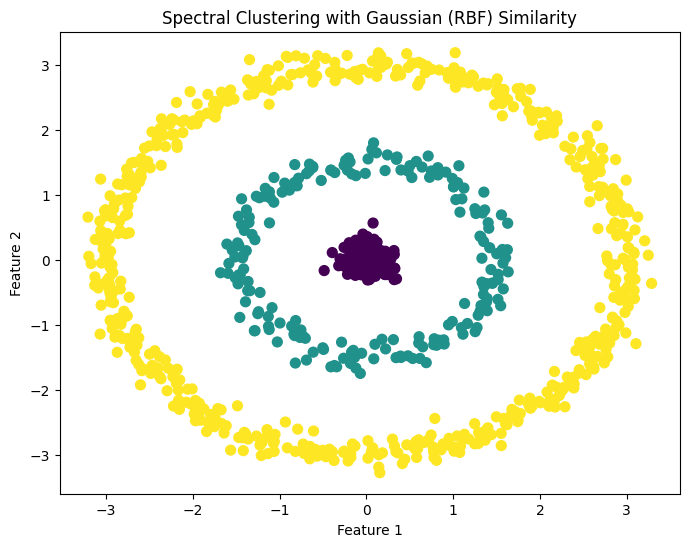

In [306]:
spectral = SpectralClustering(
    n_clusters=3,
    affinity='rbf',   # Gaussian similarity
    gamma=15,         # Controls the width of the Gaussian kernel
    assign_labels='kmeans',
    random_state=42
)
labels = spectral.fit_predict(X)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
plt.title("Spectral Clustering with Gaussian (RBF) Similarity")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Making the Adjacency Matrix

In [429]:
sigma = 3
A = -1 * np.square(X[:, None, :] - X[None, :, :]).sum(axis=-1) # Euclidian Distance
A = np.exp(A / (2*sigma**2)) # Similarities matrix.
np.fill_diagonal(A, 0)

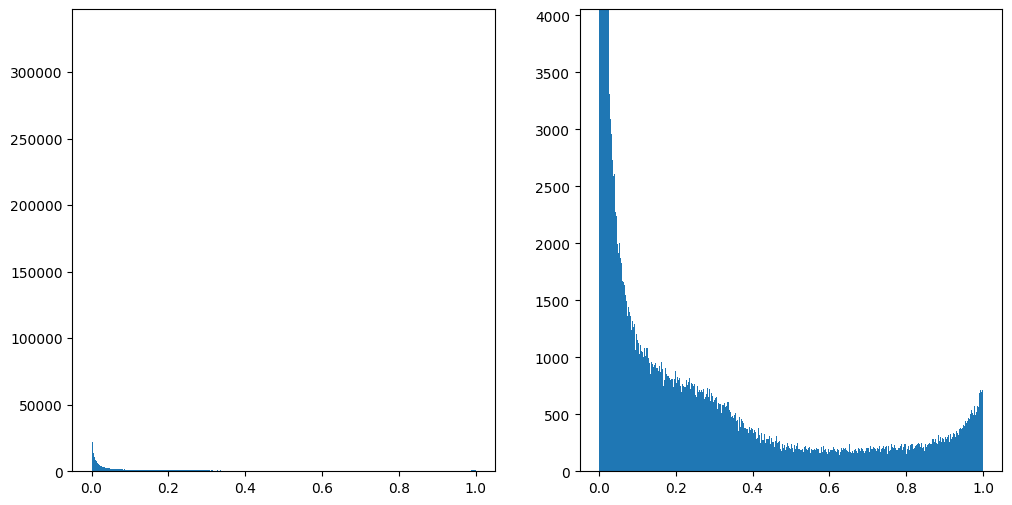

In [357]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
counts, bin_edges, patches = ax1.hist(A.flatten(), bins='auto')

ax2.hist(A.flatten(), bins='auto')
ax2.set_ylim(0, counts[10])
plt.show()

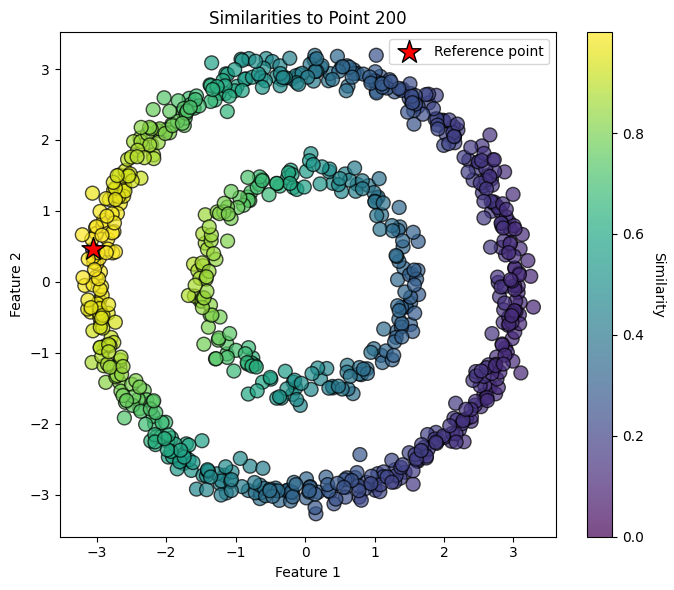

In [430]:
point_idx = 200
similarities = A[point_idx, :]
plt.figure(figsize=(7, 6))

# Plot every other point than the one selected.
scatter = plt.scatter(X[:, 0], X[:, 1], c=similarities, cmap='viridis', 
                     s=100, alpha=0.7, edgecolors='black')

# Plot the point you selected with a star.
plt.scatter(X[point_idx, 0], X[point_idx, 1], c='red', s=300, 
           marker='*', edgecolors='black', label='Reference point', zorder=5)

cbar = plt.colorbar(scatter)
cbar.set_label('Similarity', rotation=270, labelpad=15)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'Similarities to Point {point_idx}')
plt.legend()
plt.tight_layout()
plt.show()

# What the hell does this function look like?

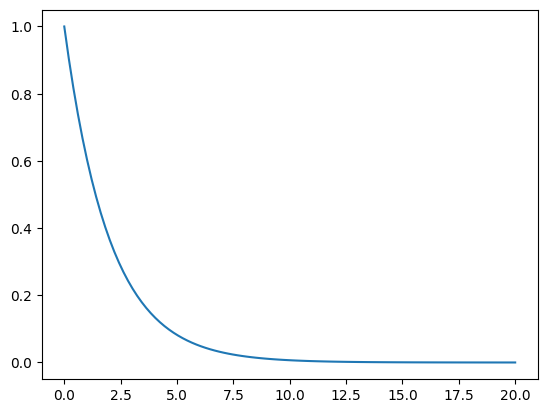

In [426]:
fun = lambda x: np.exp(-1 * np.abs(x) / (2*sigma**2))
domain = np.linspace(0, 20, 100)
y = [fun(x) for x in domain]

plt.plot(domain, y)
plt.show()

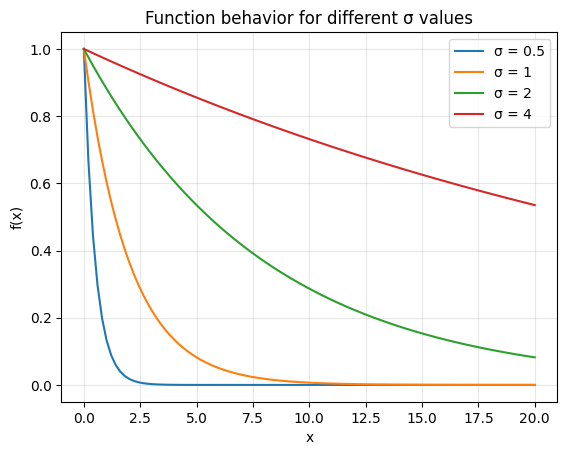

In [77]:
sigmas = [0.5, 1, 2, 4]
domain = np.linspace(0, 20, 100)

for sigma in sigmas:
    fun = lambda x, s=sigma: np.exp(-1 * np.abs(x) / (2*s**2))
    y = [fun(x) for x in domain]
    plt.plot(domain, y, label=f'σ = {sigma}')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function behavior for different σ values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualizing the graph.

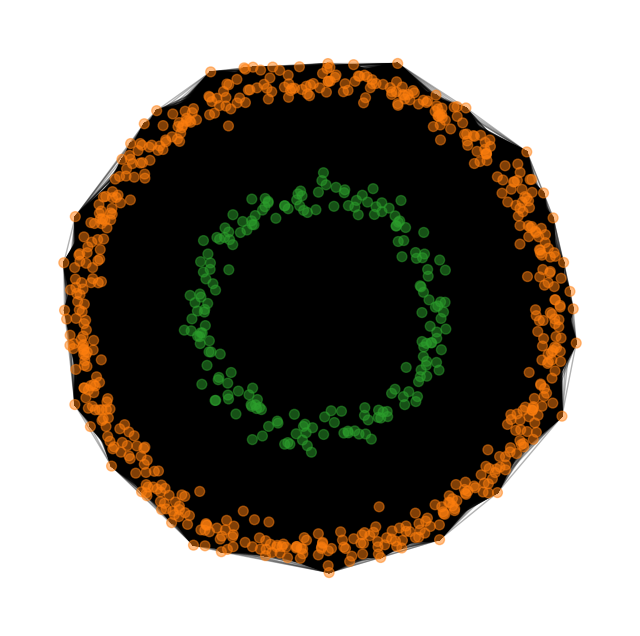

In [428]:
A1 = np.copy(A)
#A1[A1 < 0.9] = 0
G = nx.from_numpy_array(A1)

plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx_nodes(G, pos=X, node_color=y_color, node_size=50, alpha=0.5)
nx.draw_networkx_edges(G, pos=X, edge_color="black", alpha=0.3)

# The Graph Laplacian

In [433]:
# Get the identity matrix
I = np.zeros_like(A)
np.fill_diagonal(I, 1)

In [434]:
# Create the degree matrix
D = np.zeros_like(A)
np.fill_diagonal(D, np.sum(A, axis=1))
dis = np.linalg.inv(np.sqrt(D))
graph_laplacian = I - np.dot(dis, A).dot(dis)

# Eigen Values and Vectors

In [435]:
# produce the eigen values and vectors of the graph laplacian.
evals, evects = np.linalg.eig(graph_laplacian)
evals = evals.real
evects = np.array(evects.real)

# sort the eigen values.
evals_indexes = np.argsort(evals, axis=0, )
eigenvalues_sorted = np.take_along_axis(evals, evals_indexes, axis=0)

eigenvectors_sorted = evects.take(evals_indexes, axis=1)

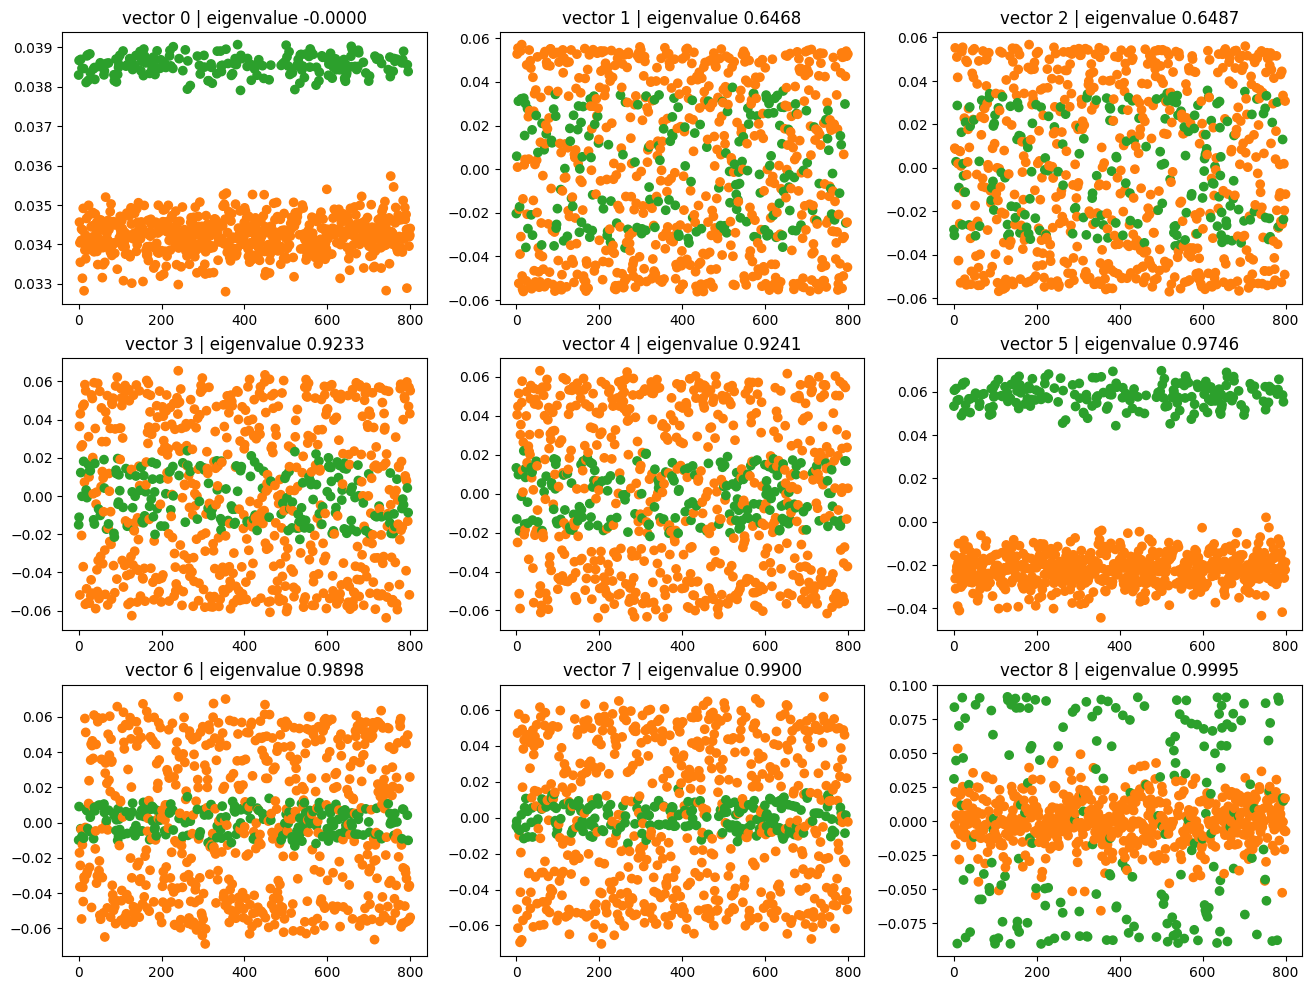

In [436]:
fig, axs = plt.subplots(3,3, figsize=(16,12))
eigen_v_x = np.linspace(0, eigenvectors_sorted.shape[0], eigenvectors_sorted.shape[0])

for j, ax in enumerate(fig.axes):
    eigen_v_y = eigenvectors_sorted[:,j]
    ax.scatter(eigen_v_x, eigen_v_y, marker='o', color=y_color)
    ax.set_title(f"vector {j} | eigenvalue {eigenvalues_sorted[j]:.4f}")

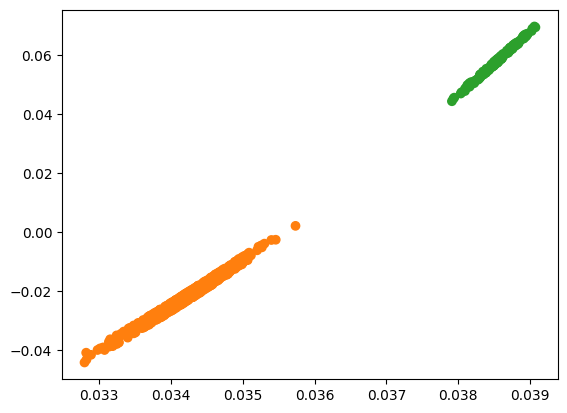

In [437]:
plt.scatter(eigenvectors_sorted[:, 0], eigenvectors_sorted[:, 5], color=y_color)

# Using our new space

In [265]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [438]:
X_transformed = eigenvectors_sorted[:, [0,5]]

scaler = StandardScaler()
scaler.fit(X_transformed)
Xts = scaler.transform(X_transformed)

In [439]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(Xts)

,n_clusters,2
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


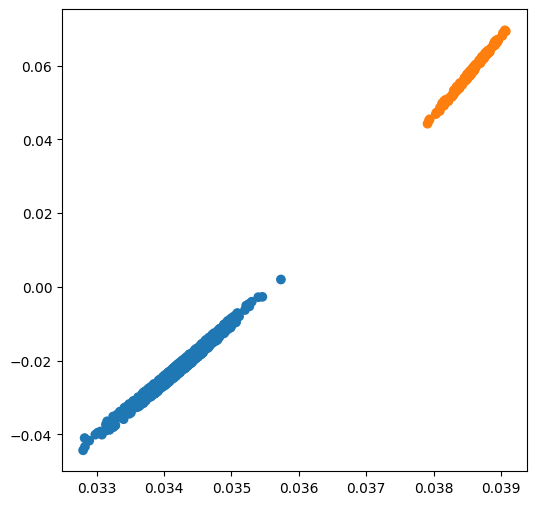

In [441]:
plt.figure(figsize=(6,6))
plt.scatter(eigenvectors_sorted[:, 0], eigenvectors_sorted[:, 5], color=np.array(plot_colors)[kmeans.labels_])

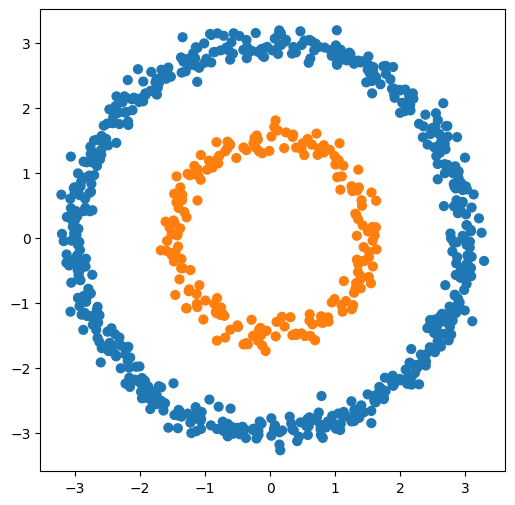

In [442]:
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], marker='o', s=40, color=np.array(plot_colors)[kmeans.labels_])
plt.show()